<a href="https://colab.research.google.com/github/bernpb/Codon_Frequency_Classification/blob/main/3-6_Regression_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Neural Networks to Solve Regression Problems

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


Because all of the features in the dataset take on wildly different ranges of values, it is a good idea to scale some of the data to help the network train to the correct values.
<br>
<br>
In this case we will scale the values by subtracting the mean of the feature and dividing by the standard deviation for each feature.  This leaves the feature centered around 0 with a unit standard deviation.



In [2]:
# Calculate the mean of the training data and then apply it
mean = train_data.mean(axis=0)
train_data-=mean

# Calculate the standard deviation of the training data, then apply it
std = train_data.std(axis=0)
train_data/=std

# Apply the mean and standard deviation values of the train data to the test data
test_data-=mean
test_data/=std

# Build the Network

In [3]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu',
                           input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    return model

### Validating our approach using K-fold cross-validation

Because we have so few samples, it would be wasteful to further split our training set into a partial training and validation set.

In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = [] # Store scores from cross_validations   

In [5]:
for i in range(k):
    print(f'Processing fold: {i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # Prepares the validation data for the "i-th" partition
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], # Prepares training data from all other partitions
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                           train_targets[(i + 1) * num_val_samples:]],
                                           axis = 0)
    
    model = build_model() # Builds the previously compiled model
    model.fit(partial_train_data, partial_train_targets,
              epochs = num_epochs, batch_size=1, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

Processing fold: 0
Processing fold: 1
Processing fold: 2
Processing fold: 3


In [6]:
print(all_scores)
print(np.mean(all_scores))

[1.9634917974472046, 2.665093421936035, 2.6373040676116943, 2.3359241485595703]
2.400453358888626


In [7]:
# The following block of code will save the validation logs at each fold

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f'Processing fold: {i}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # Prepares the validation data for the "i-th" partition
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], # Prepares training data from all other partitions
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                           train_targets[(i + 1) * num_val_samples:]],
                                           axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs,
                        batch_size  = 1, verbose  = 0)


Processing fold: 0
Processing fold: 1
Processing fold: 2
Processing fold: 3


In [8]:
    print(history.history.keys())
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


### Diving into the results

In [9]:
# Build the history of successive mean k-fold cross-validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

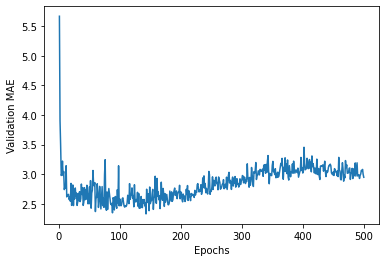

In [10]:
# Plot the validation scores

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

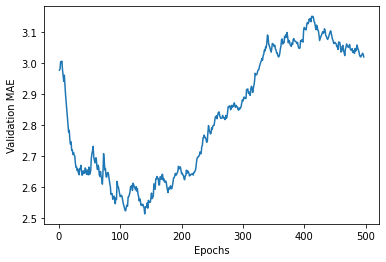

In [11]:
# The plot above shows high variance and some scaling issues
# Remove the first 3 observations to clarify things a bit

def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[3:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

We can see clearly from the plot above that the model really starts to overfit around 100 epochs

# Let's train a final model on all data, for 100 epochs

In [13]:
model = build_model() # Gets a fresh, compiled model
model.fit(train_data, train_targets,
          epochs = 100, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(f'Mean absolute error of final model: {test_mae_score}')

4/4 [==============================] - 0s 4ms/step - loss: 16.7979 - mae: 2.6315
Mean absolute error of final model: 2.6314804553985596
